In [1]:
"""Mainly Edited for private usage by:  Ioannis Agriomallos
                                        Ioanna Mitsioni
License: BSD 3 clause

============= CURRENT CODE USAGE =============
Current code trains MLP Classifiers, to classify force input samples as stable (0) or slip (1)
---- Input
-> Input samples originate from optoforce sensors and are 3D (fx,fy,fz) and come from 2 different datasets, 
   one training, containing several surfaces as well as slip-stable occurrences, 
   and one validation, containing 1 surface with slip-stable occurrences on a completely unseen task-setup.
---- Input transformation
-> Several pre-features can be taken from these inputs, but here |f| is kept.
-> Several time and frequency domain features are extracted from pre-feature windows. 
  (implemented in 'featext.py') These windows have size w and are shifted by s on each sample
-> Then a feature selection-ranking is performed using MutualVariableInformation
-> Finally PCA is performed to keep a reduced set among the best selected features
---- Training of ML Classifiers
-> Several MLP Classifiers are trained for all combinations of selected featuresets-datasets
---- Results
-> Stats of classification results are kept inside each .npz along with the respective trained model
"""
print(__doc__)
import time
start_time = time.time()
import numpy as np
from ml_training import *
import matplotlib.pyplot as plt
%matplotlib inline 
# %matplotlib qt
# inline (suitable for ipython only, shown inside browser!) or qt (suitable in general, shown in external window!)
from matplotlib.colors import ListedColormap
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D

Mainly Edited for private usage by:  Ioannis Agriomallos
                                        Ioanna Mitsioni
License: BSD 3 clause

============= CURRENT CODE USAGE =============
Current code trains MLP Classifiers, to classify force input samples as stable (0) or slip (1)
---- Input
-> Input samples originate from optoforce sensors and are 3D (fx,fy,fz) and come from 2 different datasets, 
   one training, containing several surfaces as well as slip-stable occurrences, 
   and one validation, containing 1 surface with slip-stable occurrences on a completely unseen task-setup.
---- Input transformation
-> Several pre-features can be taken from these inputs, but here |f| is kept.
-> Several time and frequency domain features are extracted from pre-feature windows. 
  (implemented in 'featext.py') These windows have size w and are shifted by s on each sample
-> Then a feature selection-ranking is performed using MutualVariableInformation
-> Finally PCA is performed to keep a reduced 

## Prepare Config struct class to pass to the ml class, responsible for all function initializations

In [2]:
class struct:
    def __init__(self):
        ####### TRAINING DEFAULTS
        self.cv = KFold(n_splits=5,random_state=42)
        self.scaler = StandardScaler() ;
        self.decomp = PCA(n_components=20)
        self.names = ["NearNb", "RBFSVM1", "MLP1", "RandFor"]
        self.classifiers = [KNeighborsClassifier(5),
                       SVC(gamma='auto', C=1),
                       MLPClassifier(solver='lbfgs',alpha=1e-4,hidden_layer_sizes=(10,10),random_state=1,verbose=True),
                       RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)]

        self.download = 0            # Download pre-computed (1) data or compute them all anew (0)
        self.delete_big_features = 1 # Delete (1) or keep (0) computed big-in-size features,
                                  # helping mainly to avoid several computations when recomputing features

        ############ INITIALISATION PARAMETERS ############
        self.window, self.shift = 1024, 20
        self.samplesperdataset = 10000
        self.havelabel = 1
        self.returntime = 0
        self.featlabel = 0         # 0: all features, 1: temporal, 2: frequency, 3: FFT only
        self.magnFFT = 0           # 0: FFT in magnitude format, 1: FFT in real and imag format,
        self.featall = 0           # 0: all, 1: feat1 (phinyomark's), 2: feat2 (golz's)
        self.CV = 5                # cross validation checks
        self.numfeat = 10          # number of features to show
        self.nfeat = 1000          # number of features to keep
        ###### Initialize necessary names and paths
        self.datapath = 'data/'
        self.datafile = self.datapath+'dataset.npz'
        self.validfile = self.datapath+'validation.mat'
        self.featpath = self.datapath+'features/'+str(self.window)+'_'+str(self.shift)+'/'
        self.allfeatpath = self.featpath+'AllFeatures/'
        self.prefeatname = 'prefeatures_zscore'+'_'+str(self.window)+'_'+str(self.shift)+'_'+str(self.samplesperdataset)
        self.prefeatfile = self.featpath+self.prefeatname+'.npz'
        self.featname = 'features_zscore'+'_'+str(self.window)+'_'+str(self.shift)+'_'+str(self.samplesperdataset)
        self.featfile = self.featpath+self.featname+'.npz'
        self.validfeatname = 'valid'+self.featname
        self.validfeatfile = self.featpath+self.validfeatname+'.npz'
        self.surffile = self.featpath+self.featname+'_2fing_6surf.npz'
        self.XYfile = self.featpath+self.featname+'_XY.npz'
        self.XYsplitfile = self.featpath+self.featname+'_XYsplit.npz'
        self.validsurffile = self.featpath+self.validfeatname+'_2fing_6surf.npz'
        self.validXYfile = self.featpath+self.validfeatname+'_XY.npz'
        self.validXYsplitfile = self.featpath+self.validfeatname+'_XYsplit.npz'
        self.respath = self.datapath+'zscore_results'
        self.toolfile = self.datapath+'bargraph.zip'
        self.toolpath = self.datapath+'bargraph-rel_4_8/'
        self.tool = './'+self.toolpath+'bargraph.pl'
######### INITIALIZE OBJECT-STRUCT WITH PARAMETERS AND PASS THEM TO ML MODULE ########
c = struct()
m = ml(c)

## DOWNLOAD NECESSARY FILES

In [3]:
download_required_files()

Necessary  data/dataset.npz  already here!
Necessary  data/validation.mat  already here!
Downloaded 575.7 MB of content in total!


## TRAINING PROCEDURE

In [4]:
# necessary steps before training
f,l,fd,m,m1,m2 = data_prep(c.datafile,scale=[-2.0])              # read input force and labels
prefeat = compute_prefeat(f)                                     # compute corresponding prefeatures
features, labels = feature_extraction(prefeat, m, c.featfile,
                                      c.featname+'_')            # feature extraction from prefeatures
# avg_feat_comp_time(prefeat)                                      # average feature extraction time
new_labels = label_cleaning(prefeat,labels,m)                    # trim labels, around change points
X,Y,Yn,Xsp,Ysp = computeXY(features,labels,new_labels,m1,m2,
                           c.XYfile,c.XYsplitfile)               # compute data and labels, trimmed and untrimmed
surf, surfla = computeXY_persurf(Xsp,Ysp,c.surffile)             # compute per surface data and labels
# training and offline testing
train_1_surface(surf,surfla)                                     # training of all combinations per 1 surface
train_2_surface(surf,surfla)                                     # training of all combinations per 2 surfaces
train_3_surface(surf,surfla)                                     # training of all combinations per 3 surfaces
train_4_surface(surf,surfla)                                     # training of all combinations per 4 surfaces
train_5_surface(surf,surfla)                                     # training of all combinations per 5 surfaces

---------------------------- LOADING DATA and COMPUTING NECESSARY STRUCTS ----------------------------
1 -> f1: (36,) (36,) (36, 4)
2 -> f2: (36,) (36,) (36, 4)
3 -> f: (72,) (72,) (72, 4)
4 -> m1,m2: 36 36 1.0 1.0
5 -> f=f+l: (72,) : [(345002, 4), (105001, 4), (210001, 4), (225002, 4), (130001, 4), (65001, 4), (195001, 4), (65001, 4), (130001, 4), (195001, 4), (65001, 4), (130001, 4), (225002, 4), (65001, 4), (130001, 4), (195001, 4), (65001, 4), (130001, 4), (75001, 4), (130001, 4), (195001, 4), (195001, 4), (130001, 4), (65001, 4), (65001, 4), (130001, 4), (195001, 4), (195001, 4), (130001, 4), (65001, 4), (65001, 4), (130001, 4), (195001, 4), (130001, 4), (195001, 4), (65001, 4), (345002, 4), (105001, 4), (210001, 4), (225002, 4), (130001, 4), (65001, 4), (195001, 4), (65001, 4), (130001, 4), (195001, 4), (65001, 4), (130001, 4), (225002, 4), (65001, 4), (130001, 4), (195001, 4), (65001, 4), (130001, 4), (75001, 4), (130001, 4), (195001, 4), (195001, 4), (130001, 4), (65001, 4), (6

sample: 25 , time(sec): 5.85 data/features/1024_20/AllFeatures/features_zscore_1024_20_10000_25.pkl.z  computing...  (1, 6449, 3107, 2)
sample: 25 , time(sec): 5.91 data/features/1024_20/AllFeatures/features_zscore_1024_20_10000_25_red10000.pkl.z (281, 3107, 2)
sample: 26 , time(sec): 8.12 data/features/1024_20/AllFeatures/features_zscore_1024_20_10000_26.pkl.z  computing...  (1, 9699, 3107, 2)
sample: 26 , time(sec): 8.18 data/features/1024_20/AllFeatures/features_zscore_1024_20_10000_26_red10000.pkl.z (278, 3107, 2)
sample: 27 , time(sec): 7.81 data/features/1024_20/AllFeatures/features_zscore_1024_20_10000_27.pkl.z  computing...  (1, 9699, 3107, 2)
sample: 27 , time(sec): 7.87 data/features/1024_20/AllFeatures/features_zscore_1024_20_10000_27_red10000.pkl.z (278, 3107, 2)
sample: 28 , time(sec): 5.06 data/features/1024_20/AllFeatures/features_zscore_1024_20_10000_28.pkl.z  computing...  (1, 6449, 3107, 2)
sample: 28 , time(sec): 5.15 data/features/1024_20/AllFeatures/features_zscore

sample: 57 , time(sec): 7.21 data/features/1024_20/AllFeatures/features_zscore_1024_20_10000_57.pkl.z  computing...  (1, 9699, 3107, 2)
sample: 57 , time(sec): 7.27 data/features/1024_20/AllFeatures/features_zscore_1024_20_10000_57_red10000.pkl.z (278, 3107, 2)
sample: 58 , time(sec): 4.77 data/features/1024_20/AllFeatures/features_zscore_1024_20_10000_58.pkl.z  computing...  (1, 6449, 3107, 2)
sample: 58 , time(sec): 4.83 data/features/1024_20/AllFeatures/features_zscore_1024_20_10000_58_red10000.pkl.z (281, 3107, 2)
sample: 59 , time(sec): 2.33 data/features/1024_20/AllFeatures/features_zscore_1024_20_10000_59.pkl.z  computing...  (1, 3199, 3107, 2)
sample: 59 , time(sec): 2.39 data/features/1024_20/AllFeatures/features_zscore_1024_20_10000_59_red10000.pkl.z (267, 3107, 2)
sample: 60 , time(sec): 2.66 data/features/1024_20/AllFeatures/features_zscore_1024_20_10000_60.pkl.z  computing...  (1, 3199, 3107, 2)
sample: 60 , time(sec): 2.71 data/features/1024_20/AllFeatures/features_zscore

sample: 33 , time(sec): 12.17 data/features/1024_20/AllFeatures/features_zscore_1024_20_10000_33_red10000.pkl.z already here! (281, 3107, 2)
sample: 34 , time(sec): 12.22 data/features/1024_20/AllFeatures/features_zscore_1024_20_10000_34_red10000.pkl.z already here! (278, 3107, 2)
sample: 35 , time(sec): 12.26 data/features/1024_20/AllFeatures/features_zscore_1024_20_10000_35_red10000.pkl.z already here! (267, 3107, 2)
sample: 36 , time(sec): 12.30 data/features/1024_20/AllFeatures/features_zscore_1024_20_10000_36_red10000.pkl.z already here! (278, 3107, 2)
sample: 37 , time(sec): 12.34 data/features/1024_20/AllFeatures/features_zscore_1024_20_10000_37_red10000.pkl.z already here! (274, 3107, 2)
sample: 38 , time(sec): 12.38 data/features/1024_20/AllFeatures/features_zscore_1024_20_10000_38_red10000.pkl.z already here! (275, 3107, 2)
sample: 39 , time(sec): 12.43 data/features/1024_20/AllFeatures/features_zscore_1024_20_10000_39_red10000.pkl.z already here! (280, 3107, 2)
sample: 40 , 

Gathered -> X[ 2 ]:  (19870, 3107, 1) , Y[ 2 ]:  (19870,) , Yn[ 2 ]:  (19870,)
Gathered, sampled to max  10000  -> X[ 2 ]:  (9935, 3107) , Y[ 2 ]:  (9935,) , Yn[ 2 ]:  (9935,)
Split -> Xsp[ 2 ]:  (8826, 3107) , Ysp[ 2 ]:  (8826,)
X,Y [0,1,2]:  (9935, 3107) (9935,) (9935, 3107) (9935,) (9935, 3107) (9935,)
Xsp,Ysp [0,1,2]:  (8826, 3107) (8826,) (8826, 3107) (8826,) (8826, 3107) (8826,)
------------------------ COMPUTING X,Y per surface CLASSIFIERS' INPUT --------------------------------
0 0 (6, 1470, 3107)
0 1 (6, 1470, 3107)
0 2 (6, 1470, 3107)
0 3 (6, 1470, 3107)
0 4 (6, 1470, 3107)
0 5 (6, 1470, 3107)
0 6 (6, 1470, 3107)
(4, 6, 1) (1470, 6, 1)
-------------------------- TRAINING all combinations per 1 surface -----------------------------------
0 0 0 0
0 1 0 0
0 2 0 0
0 3 0 0
0 0 0 1
Fitting on 0, testing on 1...
0 0 0 2
Found precomputed model of 0, tested on 1. Testing on 2...
0 0 0 3
Found precomputed model of 0, tested on 1. Testing on 3...
0 0 0 4
Found precomputed model of 0, t

0 3 5 4
Found precomputed model of 5, tested on 0. Testing on 4...
0 3 5 5
-------------------------- TRAINING all combinations per 2 surfaces ----------------------------------
0 0 0 1 0
Fitting on 0-1, cross-validating on 0...
0 1 0 1 0
Fitting on 0-1, cross-validating on 0...
0 2 0 1 0
Fitting on 0-1, cross-validating on 0...
0 3 0 1 0
Fitting on 0-1, cross-validating on 0...
0 0 0 1 1
Fitting on 0-1, cross-validating on 1...
0 0 0 1 2
Fitting on 0-1, testing on 2...
0 0 0 1 3
Found precomputed model of 01, tested on 2. Testing on 3...
0 0 0 1 4
Found precomputed model of 01, tested on 2. Testing on 4...
0 0 0 1 5
Found precomputed model of 01, tested on 2. Testing on 5...
0 0 0 2 0
Fitting on 0-2, cross-validating on 0...
0 2 0 1 1
Fitting on 0-1, cross-validating on 1...
0 2 0 1 2
Fitting on 0-1, testing on 2...
0 0 0 2 1
Fitting on 0-2, testing on 1...
0 2 0 1 3
Found precomputed model of 01, tested on 2. Testing on 3...
0 2 0 1 4
Found precomputed model of 01, tested on 2. Testi

0 2 1 3 0
Fitting on 1-3, testing on 0...
0 2 1 3 1
Fitting on 1-3, cross-validating on 1...
0 0 2 5 3
Found precomputed model of 25, tested on 0. Testing on 3...
0 0 2 5 4
Found precomputed model of 25, tested on 0. Testing on 4...
0 0 2 5 5
Fitting on 2-5, cross-validating on 5...
0 0 3 4 0
Fitting on 3-4, testing on 0...
0 0 3 4 1
Found precomputed model of 34, tested on 0. Testing on 1...
0 0 3 4 2
Found precomputed model of 34, tested on 0. Testing on 2...
0 0 3 4 3
Fitting on 3-4, cross-validating on 3...
0 0 3 4 4
Fitting on 3-4, cross-validating on 4...
0 0 3 4 5
Found precomputed model of 34, tested on 0. Testing on 5...
0 0 3 5 0
Fitting on 3-5, testing on 0...
0 0 3 5 1
Found precomputed model of 35, tested on 0. Testing on 1...
0 0 3 5 2
Found precomputed model of 35, tested on 0. Testing on 2...
0 0 3 5 3
Fitting on 3-5, cross-validating on 3...
0 2 1 3 2
Found precomputed model of 13, tested on 0. Testing on 2...
0 2 1 3 3
Fitting on 1-3, cross-validating on 3...
0 2 1 3 

Found precomputed model of 23, tested on 0. Testing on 4...
0 1 2 3 5
Found precomputed model of 23, tested on 0. Testing on 5...
0 1 2 4 0
Fitting on 2-4, testing on 0...
0 1 2 4 1
Found precomputed model of 24, tested on 0. Testing on 1...
0 1 2 4 2
Fitting on 2-4, cross-validating on 2...
0 3 1 3 2
Found precomputed model of 13, tested on 0. Testing on 2...
0 3 1 3 3
Fitting on 1-3, cross-validating on 3...
0 3 1 3 4
Found precomputed model of 13, tested on 0. Testing on 4...
0 3 1 3 5
Found precomputed model of 13, tested on 0. Testing on 5...
0 3 1 4 0
Fitting on 1-4, testing on 0...
0 3 1 4 1
Fitting on 1-4, cross-validating on 1...
0 1 2 4 3
Found precomputed model of 24, tested on 0. Testing on 3...
0 1 2 4 4
Fitting on 2-4, cross-validating on 4...
0 1 2 4 5
Found precomputed model of 24, tested on 0. Testing on 5...
0 1 2 5 0
Fitting on 2-5, testing on 0...
0 1 2 5 1
Found precomputed model of 25, tested on 0. Testing on 1...
0 1 2 5 2
Fitting on 2-5, cross-validating on 2...

0 0 0 2 3 5
Found precomputed model of 023, tested on 1. Testing on 5...
0 0 0 2 4 0
Fitting on 0-2-4, cross-validating on 0...
0 2 0 1 4 1
Fitting on 0-1-4, cross-validating on 1...
0 2 0 1 4 2
Fitting on 0-1-4, testing on 2...
0 3 0 1 2 4
Found precomputed model of 012, tested on 3. Testing on 4...
0 3 0 1 2 5
Found precomputed model of 012, tested on 3. Testing on 5...
0 3 0 1 3 0
Fitting on 0-1-3, cross-validating on 0...
0 0 0 2 4 1
Fitting on 0-2-4, testing on 1...
0 2 0 1 4 3
Found precomputed model of 014, tested on 2. Testing on 3...
0 2 0 1 4 4
Fitting on 0-1-4, cross-validating on 4...
0 2 0 1 4 5
Found precomputed model of 014, tested on 2. Testing on 5...
0 2 0 1 5 0
Fitting on 0-1-5, cross-validating on 0...
0 0 0 2 4 2
Fitting on 0-2-4, cross-validating on 2...
0 0 0 2 4 3
Found precomputed model of 024, tested on 1. Testing on 3...
0 0 0 2 4 4
Fitting on 0-2-4, cross-validating on 4...
0 0 0 2 4 5
Found precomputed model of 024, tested on 1. Testing on 5...
0 0 0 2 5 0


0 0 2 3 5 0
Fitting on 2-3-5, testing on 0...
0 3 0 1 4 3
Found precomputed model of 014, tested on 2. Testing on 3...
0 3 0 1 4 4
Fitting on 0-1-4, cross-validating on 4...
0 3 0 1 4 5
Found precomputed model of 014, tested on 2. Testing on 5...
0 2 0 3 5 1
Fitting on 0-3-5, testing on 1...
0 3 0 1 5 0
Fitting on 0-1-5, cross-validating on 0...
0 0 2 3 5 1
Found precomputed model of 235, tested on 0. Testing on 1...
0 0 2 3 5 2
Fitting on 2-3-5, cross-validating on 2...
0 2 0 3 5 2
Found precomputed model of 035, tested on 1. Testing on 2...
0 2 0 3 5 3
Fitting on 0-3-5, cross-validating on 3...
0 2 0 3 5 4
Found precomputed model of 035, tested on 1. Testing on 4...
0 2 0 3 5 5
Fitting on 0-3-5, cross-validating on 5...
0 2 0 4 5 0
Fitting on 0-4-5, cross-validating on 0...
0 0 2 3 5 3
Fitting on 2-3-5, cross-validating on 3...
0 0 2 3 5 4
Found precomputed model of 235, tested on 0. Testing on 4...
0 0 2 3 5 5
Fitting on 2-3-5, cross-validating on 5...
0 0 2 4 5 0
Fitting on 2-4-5, 

0 2 3 4 5 2
Found precomputed model of 345, tested on 0. Testing on 2...
0 2 3 4 5 3
Fitting on 3-4-5, cross-validating on 3...
0 1 0 4 5 2
Found precomputed model of 045, tested on 1. Testing on 2...
0 1 0 4 5 3
Found precomputed model of 045, tested on 1. Testing on 3...
0 1 0 4 5 4
Fitting on 0-4-5, cross-validating on 4...
0 1 0 4 5 5
Fitting on 0-4-5, cross-validating on 5...
0 1 1 2 3 0
Fitting on 1-2-3, testing on 0...
0 3 0 2 5 1
Fitting on 0-2-5, testing on 1...
0 1 1 2 3 1
Fitting on 1-2-3, cross-validating on 1...
0 2 3 4 5 4
Fitting on 3-4-5, cross-validating on 4...
0 2 3 4 5 5
Fitting on 3-4-5, cross-validating on 5...
0 3 0 2 5 2
Fitting on 0-2-5, cross-validating on 2...
0 3 0 2 5 3
Found precomputed model of 025, tested on 1. Testing on 3...
0 3 0 2 5 4
Found precomputed model of 025, tested on 1. Testing on 4...
0 3 0 2 5 5
Fitting on 0-2-5, cross-validating on 5...
0 3 0 3 4 0
Fitting on 0-3-4, cross-validating on 0...
0 1 1 2 3 2
Fitting on 1-2-3, cross-validating o

0 3 2 3 5 5
Fitting on 2-3-5, cross-validating on 5...
0 3 2 4 5 0
Fitting on 2-4-5, testing on 0...
0 3 2 4 5 1
Found precomputed model of 245, tested on 0. Testing on 1...
0 3 2 4 5 2
Fitting on 2-4-5, cross-validating on 2...
0 3 2 4 5 3
Found precomputed model of 245, tested on 0. Testing on 3...
0 3 2 4 5 4
Fitting on 2-4-5, cross-validating on 4...
0 3 2 4 5 5
Fitting on 2-4-5, cross-validating on 5...
0 3 3 4 5 0
Fitting on 3-4-5, testing on 0...
0 3 3 4 5 1
Found precomputed model of 345, tested on 0. Testing on 1...
0 3 3 4 5 2
Found precomputed model of 345, tested on 0. Testing on 2...
0 3 3 4 5 3
Fitting on 3-4-5, cross-validating on 3...
0 3 3 4 5 4
Fitting on 3-4-5, cross-validating on 4...
0 3 3 4 5 5
Fitting on 3-4-5, cross-validating on 5...
-------------------------- TRAINING all combinations per 4 surfaces ----------------------------------
0 0 0 1 2 3 0
Fitting on 0-1-2-3, cross-validating on 0...
0 1 0 1 2 3 0
Fitting on 0-1-2-3, cross-validating on 0...
0 2 0 1 2 

Found precomputed model of 1234, tested on 0. Testing on 5...
0 0 1 2 3 5 0
Fitting on 1-2-3-5, testing on 0...
0 0 1 2 3 5 1
Fitting on 1-2-3-5, cross-validating on 1...
0 2 0 1 4 5 1
Fitting on 0-1-4-5, cross-validating on 1...
0 2 0 1 4 5 2
Fitting on 0-1-4-5, testing on 2...
0 3 0 1 2 4 4
Fitting on 0-1-2-4, cross-validating on 4...
0 3 0 1 2 4 5
Found precomputed model of 0124, tested on 3. Testing on 5...
0 3 0 1 2 5 0
Fitting on 0-1-2-5, cross-validating on 0...
0 1 0 1 2 5 4
Found precomputed model of 0125, tested on 3. Testing on 4...
0 1 0 1 2 5 5
Fitting on 0-1-2-5, cross-validating on 5...
0 1 0 1 3 4 0
Fitting on 0-1-3-4, cross-validating on 0...
0 2 0 1 4 5 3
Found precomputed model of 0145, tested on 2. Testing on 3...
0 2 0 1 4 5 4
Fitting on 0-1-4-5, cross-validating on 4...
0 2 0 1 4 5 5
Fitting on 0-1-4-5, cross-validating on 5...
0 2 0 2 3 4 0
Fitting on 0-2-3-4, cross-validating on 0...
0 0 1 2 3 5 2
Fitting on 1-2-3-5, cross-validating on 2...
0 0 1 2 3 5 3
Fittin

0 1 0 2 3 5 5
Fitting on 0-2-3-5, cross-validating on 5...
0 1 0 2 4 5 0
Fitting on 0-2-4-5, cross-validating on 0...
0 3 0 1 4 5 1
Fitting on 0-1-4-5, cross-validating on 1...
0 3 0 1 4 5 2
Fitting on 0-1-4-5, testing on 2...
0 1 0 2 4 5 1
Fitting on 0-2-4-5, testing on 1...
0 3 0 1 4 5 3
Found precomputed model of 0145, tested on 2. Testing on 3...
0 3 0 1 4 5 4
Fitting on 0-1-4-5, cross-validating on 4...
0 3 0 1 4 5 5
Fitting on 0-1-4-5, cross-validating on 5...
0 3 0 2 3 4 0
Fitting on 0-2-3-4, cross-validating on 0...
0 1 0 2 4 5 2
Fitting on 0-2-4-5, cross-validating on 2...
0 1 0 2 4 5 3
Found precomputed model of 0245, tested on 1. Testing on 3...
0 1 0 2 4 5 4
Fitting on 0-2-4-5, cross-validating on 4...
0 1 0 2 4 5 5
Fitting on 0-2-4-5, cross-validating on 5...
0 1 0 3 4 5 0
Fitting on 0-3-4-5, cross-validating on 0...
0 1 0 3 4 5 1
Fitting on 0-3-4-5, testing on 1...
0 1 0 3 4 5 2
Found precomputed model of 0345, tested on 1. Testing on 2...
0 1 0 3 4 5 3
Fitting on 0-3-4-5

0 1 0 1 2 3 4 5
Fitting on 0-1-2-3-4, testing on 5...
0 2 0 1 2 3 5 1
Fitting on 0-1-2-3-5, cross-validating on 1...
0 2 0 1 2 3 5 2
Fitting on 0-1-2-3-5, cross-validating on 2...
0 2 0 1 2 3 5 3
Fitting on 0-1-2-3-5, cross-validating on 3...
0 2 0 1 2 3 5 4
Fitting on 0-1-2-3-5, testing on 4...
0 0 0 1 3 4 5 1
Fitting on 0-1-3-4-5, cross-validating on 1...
0 0 0 1 3 4 5 2
Fitting on 0-1-3-4-5, testing on 2...
0 1 0 1 2 3 5 0
Fitting on 0-1-2-3-5, cross-validating on 0...
0 2 0 1 2 3 5 5
Fitting on 0-1-2-3-5, cross-validating on 5...
0 2 0 1 2 4 5 0
Fitting on 0-1-2-4-5, cross-validating on 0...
0 0 0 1 3 4 5 3
Fitting on 0-1-3-4-5, cross-validating on 3...
0 0 0 1 3 4 5 4
Fitting on 0-1-3-4-5, cross-validating on 4...
0 0 0 1 3 4 5 5
Fitting on 0-1-3-4-5, cross-validating on 5...
0 0 0 2 3 4 5 0
Fitting on 0-2-3-4-5, cross-validating on 0...
0 3 0 1 2 3 4 1
Fitting on 0-1-2-3-4, cross-validating on 1...
0 3 0 1 2 3 4 2
Fitting on 0-1-2-3-4, cross-validating on 2...
0 3 0 1 2 3 4 3
Fit

## RESULT REPORTING

---------------------------- Generating perf files for 1 surface -------------------------------------
---------------------------- Generating perf files for 2 surfaces ------------------------------------
---------------------------- Generating perf files for 3 surfaces ------------------------------------
---------------------------- Generating perf files for 4 surfaces ------------------------------------
---------------------------- Generating perf files for 5 surfaces ------------------------------------
---------------------------- Generating bar graphs for 1 surfaces ------------------------------------
---------------------------- Generating bar graphs for 2 surfaces ------------------------------------
---------------------------- Generating bar graphs for 3 surfaces ------------------------------------
---------------------------- Generating bar graphs for 4 surfaces ------------------------------------
---------------------------- Generating bar graphs for 5 surfaces -------

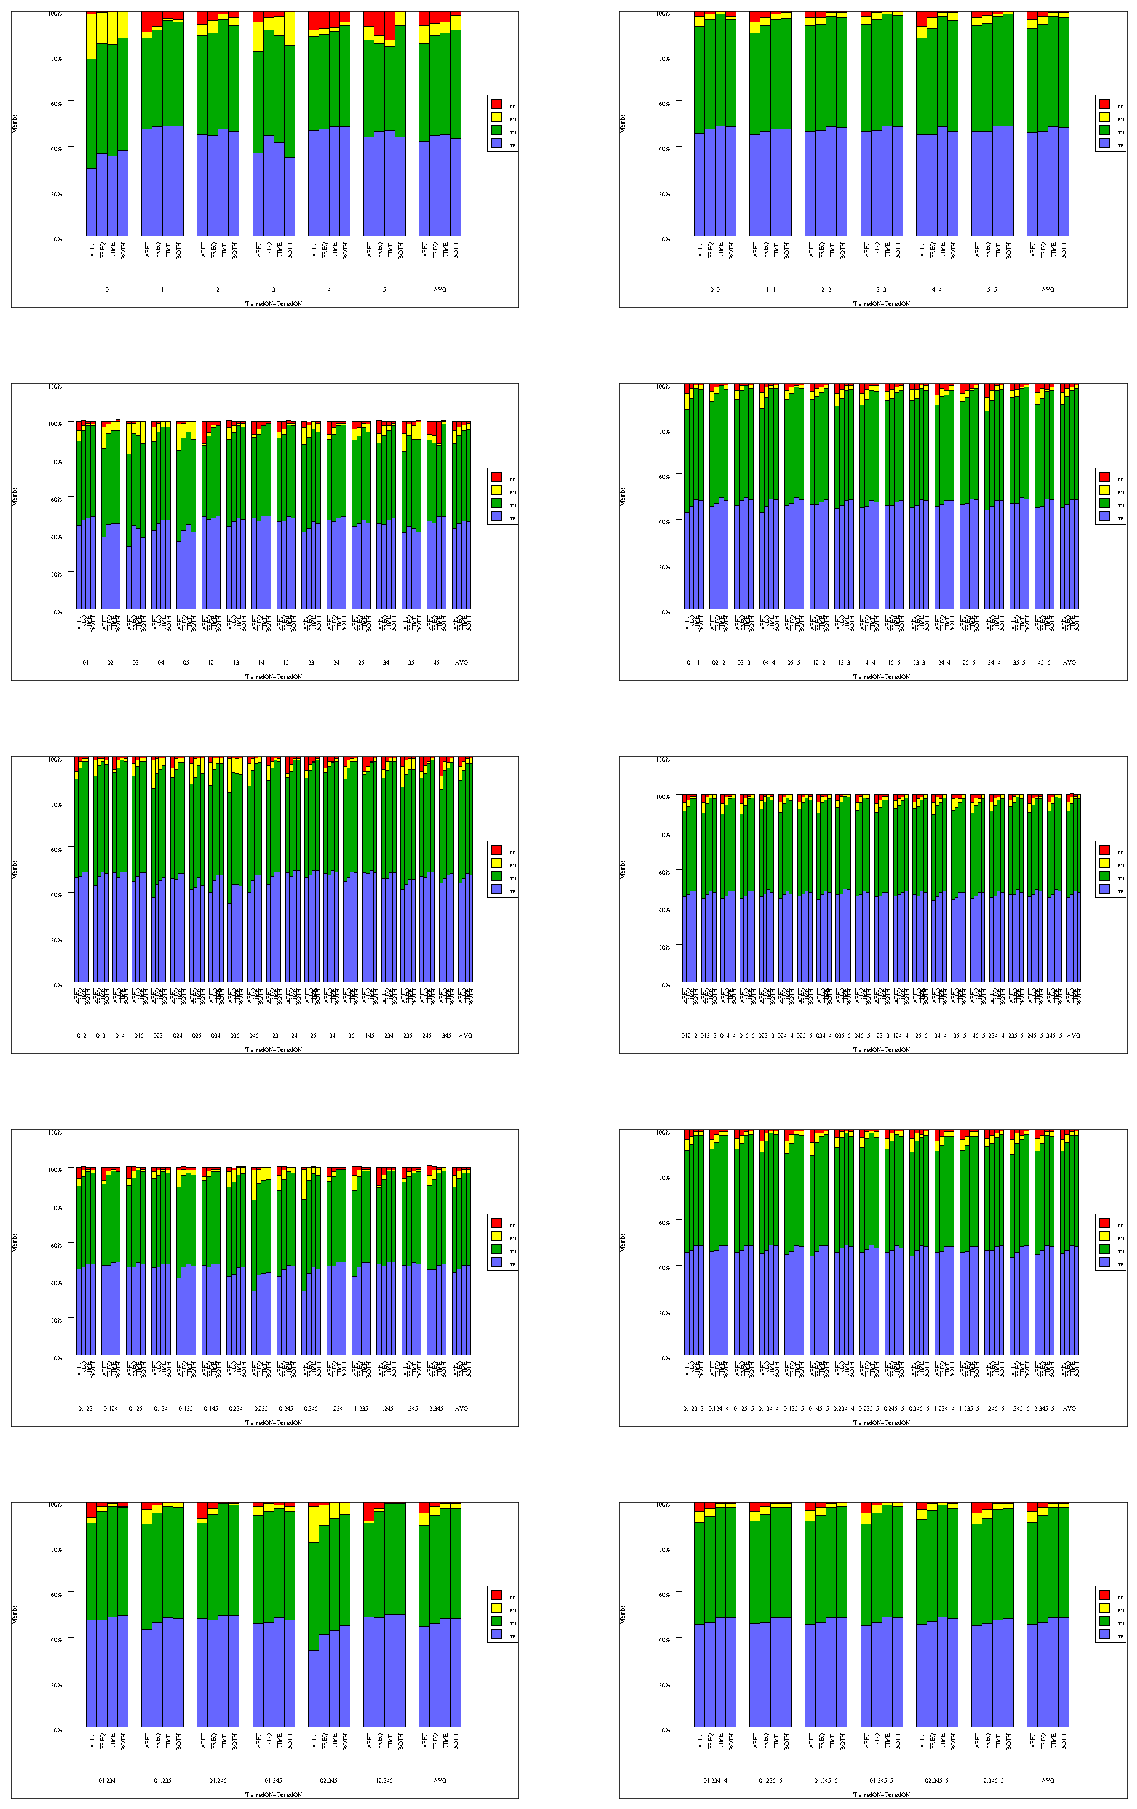

In [5]:
# generate files with stats
bargraph_perf_gen1(6)
bargraph_perf_gen2(6)
bargraph_perf_gen3(6)
bargraph_perf_gen4(6)
bargraph_perf_gen5(6)
# use the bargraph tool to plot graphs from generated files
# -left column cross-accuracy (trained on one, tested on all the others), 
# -right column self-accuracy (trained and tested on the same)
# -each row i represents training only with i surfaces.
# -each stack represents a training group, each bar represents a subfeatureset(AFFT,FREQ,TIME,BOTH)
# -blue,green,yellow,red : TP,TN,FN,FP
plt.figure(figsize=(20,40))
for i in range(5):
    make_bargraphs_from_perf(i)

## ONLINE TESTING PROCEDURE

In [6]:
# same necessary steps as in training for data preparation
f,l,fd,member,m1,m2 = data_prep(c.validfile)
prefeat = compute_prefeat(f)
features, labels = feature_extraction(prefeat, member, c.validfeatfile, 'validfeat_')
new_labels = label_cleaning(prefeat,labels,member)
X,Y,Yn,Xsp,Ysp = computeXY(features,labels,new_labels,m1,m2,c.validXYfile,c.validXYsplitfile)
surf, surfla = computeXY_persurf(Xsp,Ysp,c.validsurffile)

---------------------------- LOADING DATA and COMPUTING NECESSARY STRUCTS ----------------------------
1 -> f1: (1, 1) (1, 1) (1, 1)
2 -> f2: (1, 1) (1, 1) (1, 1)
3 -> f: (2, 1) (2, 1) (2, 1)
4 -> m1,m2: 1 1 1.0 1.0
5 -> f=f+l: (2, 65000, 4) : [(65000, 4), (65000, 4)]
7 -> fscaled:  (2, 65000, 4) (2,) (2,) (2, 2)
--------------------------------------- COMPUTING PREFEATURES ----------------------------------------
(2,) : [(65000, 2), (65000, 2)]
---------------------------------------- FEATURE EXTRACTION ------------------------------------------
sample: 0 , time(sec): 1.15 data/features/1024_20/AllFeatures/validfeat_0_red10000.pkl.z already here! (3199, 3107, 2)
sample: 1 , time(sec): 2.25 data/features/1024_20/AllFeatures/validfeat_1_red10000.pkl.z already here! (3199, 3107, 2)
Features NOT FOUND PRECOMPUTED! Feature Computation DONE in: 2.32029795647 sec 
features:  (2,) [(3199, 3107, 1), (3199, 3107, 1)]
labels:  (2,) [(3199,), (3199,)]
features:  (2,) , labels:  (2,)
----------- K

## VISUALIZING ONLINE TESTING PROCEDURE

(3199,) (2769,) (2769,)
(2650,) (2650,)


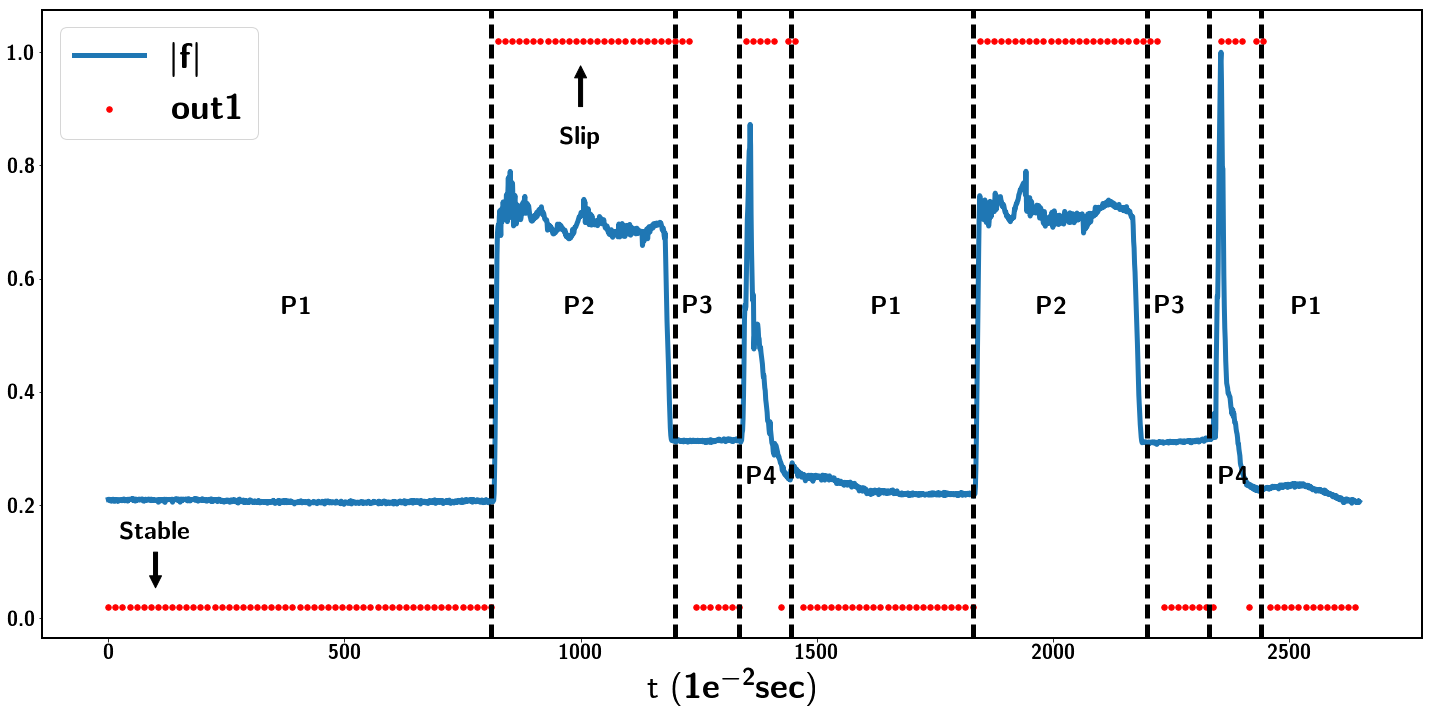

In [7]:
window=c.window
subfeats = ['AFFT','FREQ','TIME','BOTH']
feats = ['fnorm','ftfn','fnormftfn']
matplotlib.rcParams['text.usetex'] = True

fileid = filename1(0,3,0,5)
fileidb = filename1(0,0,0,5)
fileid5 = filename5(0,3,0,1,2,3,4,5)
fileid5b = filename5(0,0,0,1,2,3,4,5)
model = np.load(fileid)['model'][0]
modelb = np.load(fileidb)['model'][0]
model5 = np.load(fileid5)['model'][0]
model5b = np.load(fileid5b)['model'][0]
Yout = model.predict(X[0])
Youtb = modelb.predict(Xsp[0][:,-window-2:-window/2-1])
Yout5 = model5.predict(Xsp[0])
Yout5b = model5b.predict(Xsp[0][:,-window-2:-window/2-1])
print Yout.shape, Yout5.shape, Yout5b.shape
plt.rc('text', usetex=True)
plt.rc('axes', linewidth=2)
plt.rc('font', weight='bold')
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
offset = 2000-window
endset = 2650
skipf = 20
skipy = 15
ax = plt.figure(figsize=(20,10))
tf = np.linalg.norm(f[0][offset+window::skipf,:3][:endset],axis=1)
p1, = plt.plot(tf/max(tf),linewidth=5)
ty = Yout[offset/skipf:][:endset]+0.02
print tf.shape, ty.shape
p = plt.scatter(range(len(tf))[::skipy],ty[::skipy],color='red',s=30)
plt.hold
plt.text(100, 0.15, r'\textbf{Stable}', ha="center", va="center", rotation=0,
            size=25)
plt.text(1000, 0.85, r'\textbf{Slip}', ha="center", va="center", rotation=0,
            size=25)
plt.annotate('', fontsize=10, xy=(100, 0.05), xytext=(100, 0.12),
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('', xy=(1000, 0.98), xytext=(1000, 0.9),
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.text(400, 0.55, r'\textbf{P1}', ha="center", va="center", rotation=0,
            size=25)
plt.axvline(x=810,linestyle='dashed',color='black',linewidth=5)
plt.text(1000, 0.55, r'\textbf{P2}', ha="center", va="center", rotation=0,
            size=25)
plt.axvline(x=1200,linestyle='dashed',color='black',linewidth=5)
plt.text(1250, 0.55, r'\textbf{P3}', ha="center", va="center", rotation=0,
            size=25)
plt.axvline(x=1335,linestyle='dashed',color='black',linewidth=5)
plt.text(1385, 0.25, r'\textbf{P4}', ha="center", va="center", rotation=0,
            size=25)
plt.axvline(x=1445,linestyle='dashed',color='black',linewidth=5)
plt.text(1650, 0.55, r'\textbf{P1}', ha="center", va="center", rotation=0,
            size=25)
plt.axvline(x=1830,linestyle='dashed',color='black',linewidth=5)
plt.text(2000, 0.55, r'\textbf{P2}', ha="center", va="center", rotation=0,
            size=25)
plt.axvline(x=2200,linestyle='dashed',color='black',linewidth=5)
plt.text(2250, 0.55, r'\textbf{P3}', ha="center", va="center", rotation=0,
            size=25)
plt.axvline(x=2330,linestyle='dashed',color='black',linewidth=5)
plt.text(2385, 0.25, r'\textbf{P4}', ha="center", va="center", rotation=0,
            size=25)
plt.axvline(x=2440,linestyle='dashed',color='black',linewidth=5)
plt.text(2540, 0.55, r'\textbf{P1}', ha="center", va="center", rotation=0,
            size=25)
plt.xlabel(r't ($1e^{-2} sec$)',fontsize=35)
# plt.yticks([])
plt.legend([p1,p],[r'$|\textbf{f}|$',r'\textbf{out1}'],loc=2, prop={'size': 35})
plt.tick_params(labelsize=20)
plt.tight_layout()
savefig(c.datapath+'validation.pdf', bbox_inches='tight')


## Adaptive Scaling (mean(training_stable)/fdes) on new datasets with higher desired normal forces

In [16]:
tsd = ['ati_new_fd1.0N_kp3.5_152Hz_validation',
       'ati_new_fd1.5N_kp3_152Hz_validation',
       'ati_new_fd1.0N_kp3.5_326Hz_validation',
       'ati_new_fd1.5N_kp3_326Hz_validation',
       'ati_new_fd1.0N_kp3.5_836Hz_validation',
       'ati_new_fd1.5N_kp3.5_836Hz_validation',
       'ati_new_fd1N_kp3_nofilt_validation',
       'ati_new_fd1.5N_kp3_nofilt_validation',
       'ati_new_fd5N_kp2_326Hz_validation', 
       'ati_new_fd10N_kp2_326Hz_validation']
fdes = [1.0, 1.5, 1.0, 1.5, 1.0, 1.5, 1.0, 1.5, 5, 10]
nd = [6, 6, 6, 6, 6, 6, 6, 6, 5, 4]
for sc in [-2.0]:
    print "-------- SCALING = ",sc,"--------"
    for i in range(len(tsd)):
        ####### NEWER TESTING DATA FROM ATI F/T SENSOR TRANSLATIONAL CASE
        prediction(tsd[i]+'.mat',scale=sc,fdes=fdes[i],n=nd[i])
        ####### NEWER TESTING DATA FROM ATI F/T SENSOR ROTATIONAL CASE
        prediction(tsd[i]+'_rot.mat',scale=sc,fdes=fdes[i],n=nd[i])

-------- SCALING =  -2.0 --------
Filename for prediction: ati_new_fd1.0N_kp3.5_152Hz_validation.mat
Accuracy for surface  0 0.890520694259 0.967957276368
F1score for surface   0 0.89124668435 0.969773299748
TN(stable) and TP(slip) for surface  0 0.948424068768 0.84 | 0.974212034384 0.9625
Accuracy for surface  1 0.894526034713 0.970627503338
F1score for surface   1 0.893098782138 0.971722365039
TN(stable) and TP(slip) for surface  1 0.974212034384 0.825 | 1.0 0.945
Accuracy for surface  2 0.890520694259 0.798397863818
F1score for surface   2 0.89124668435 0.770167427702
TN(stable) and TP(slip) for surface  2 0.948424068768 0.84 | 0.988538681948 0.6325
Accuracy for surface  3 0.906542056075 0.958611481976
F1score for surface   3 0.904891304348 0.960102960103
TN(stable) and TP(slip) for surface  3 0.991404011461 0.8325 | 0.988538681948 0.9325
Accuracy for surface  4 0.949265687583 0.81041388518
F1score for surface   4 0.951282051282 0.788059701493
TN(stable) and TP(slip) for surface  4 

Accuracy for surface  4 0.853530031612 0.63645943098
F1score for surface   4 0.799422799423 0.279749478079
TN(stable) and TP(slip) for surface  4 0.970856102004 0.6925 | 0.978142076503 0.1675
Accuracy for surface  5 0.624868282403 0.68177028451
F1score for surface   5 0.513661202186 0.456834532374
TN(stable) and TP(slip) for surface  5 0.737704918033 0.47 | 0.947176684882 0.3175
Accuracy for dataset    0.793818054092 0.688795223042
F1score for dataset    0.703385548257 0.475429248076
TN(stable) and TP(slip) for dataset  0.949605343048 0.58 | 0.946873102611 0.334583333333
Filename for prediction: ati_new_fd1.5N_kp3_326Hz_validation.mat
Accuracy for surface  0 0.861148197597 0.902536715621
F1score for surface   0 0.857923497268 0.910429447853
TN(stable) and TP(slip) for surface  0 0.948424068768 0.785 | 0.873925501433 0.9275
Accuracy for surface  1 0.837116154873 0.849132176235
F1score for surface   1 0.84358974359 0.861008610086
TN(stable) and TP(slip) for surface  1 0.853868194842 0.82

Filename for prediction: ati_new_fd1.5N_kp3.5_836Hz_validation_rot.mat
Accuracy for surface  0 0.7664 0.5264
F1score for surface   0 0.710317460317 0.16384180791
TN(stable) and TP(slip) for surface  0 1.0 0.550769230769 | 1.0 0.0892307692308
Accuracy for surface  1 0.7448 0.5256
F1score for surface   1 0.674821610601 0.161244695898
TN(stable) and TP(slip) for surface  1 1.0 0.509230769231 | 1.0 0.0876923076923
Accuracy for surface  2 0.7624 0.5784
F1score for surface   2 0.703888334995 0.318240620957
TN(stable) and TP(slip) for surface  2 1.0 0.543076923077 | 1.0 0.189230769231
Accuracy for surface  3 0.7312 0.5208
F1score for surface   3 0.651452282158 0.145506419401
TN(stable) and TP(slip) for surface  3 1.0 0.483076923077 | 1.0 0.0784615384615
Accuracy for surface  4 0.7904 0.5328
F1score for surface   4 0.75329566855 0.191135734072
TN(stable) and TP(slip) for surface  4 0.98 0.615384615385 | 0.995 0.106153846154
Accuracy for surface  5 0.6824 0.4808
F1score for surface   5 0.560354

Accuracy for dataset    0.833853006682 0.855233853007
F1score for dataset    0.848435595286 0.868898749496
TN(stable) and TP(slip) for dataset  0.979881656805 0.745714285714 | 0.997633136095 0.769285714286
Filename for prediction: ati_new_fd5N_kp2_326Hz_validation_rot.mat
Accuracy for surface  0 0.634390651085 0.589315525876
F1score for surface   0 0.561122244489 0.562277580071
TN(stable) and TP(slip) for surface  0 0.802675585284 0.466666666667 | 0.652173913043 0.526666666667
Accuracy for surface  1 0.792988313856 0.711185308848
F1score for surface   1 0.739495798319 0.594847775176
TN(stable) and TP(slip) for surface  1 1.0 0.586666666667 | 1.0 0.423333333333
Accuracy for surface  2 0.674457429048 0.692821368948
F1score for surface   2 0.518518518519 0.557692307692
TN(stable) and TP(slip) for surface  2 1.0 0.35 | 1.0 0.386666666667
Accuracy for surface  3 0.724540901503 0.617696160267
F1score for surface   3 0.627539503386 0.382749326146
TN(stable) and TP(slip) for surface  3 0.98662

## Check the training forces and compare them with testing ones (2.86 1.35 2.12 1.68)

In [14]:
printit = False
f,_,_,_,_,_ = data_prep(c.datafile,printit=printit)                        # read training input force
pf = compute_prefeat(f,printit=printit)                                  # compute corresponding prefeatures
fv,_,_,_,_,_ = data_prep(c.validfile,printit=printit)                      # read validation input force
pfv = compute_prefeat(fv,printit=printit)                                # compute corresponding prefeatures

atifiles = ['ati_new_fd1.0N_kp3.5_152Hz_validation.mat',
            'ati_new_fd1.0N_kp3.5_152Hz_validation_rot.mat',
            'ati_new_fd1.5N_kp3_152Hz_validation.mat',
            'ati_new_fd1.5N_kp3_152Hz_validation_rot.mat',
            'ati_new_fd1.0N_kp3.5_326Hz_validation.mat',
            'ati_new_fd1.0N_kp3.5_326Hz_validation_rot.mat',
            'ati_new_fd1.5N_kp3_326Hz_validation.mat',
            'ati_new_fd1.5N_kp3_326Hz_validation_rot.mat',
            'ati_new_fd1.0N_kp3.5_836Hz_validation.mat',
            'ati_new_fd1.0N_kp3.5_836Hz_validation_rot.mat',
            'ati_new_fd1.5N_kp3.5_836Hz_validation.mat',
            'ati_new_fd1.5N_kp3.5_836Hz_validation_rot.mat',
            'ati_new_fd1N_kp3_nofilt_validation.mat',
            'ati_new_fd1N_kp3_nofilt_validation_rot.mat',
            'ati_new_fd1.5N_kp3_nofilt_validation.mat',
            'ati_new_fd1.5N_kp3_nofilt_validation_rot.mat']
atiftr = []
atifrt = []
for filen in atifiles:
    tf,_,_,_,_,_ = data_prep(c.datapath+filen,k=1,printit=printit)
    ptf = compute_prefeat(tf,printit=printit)
    if filen[-7:-4] == 'rot':
        atifrt.append(ptf)
    else:
        atiftr.append(ptf)
atiftr = np.array(atiftr).flatten()
atifrt = np.array(atifrt).flatten()

plist = [pf, pfv, atiftr, atifrt]
pname = ['train', 'valid','atitran','atirot']
print pf.shape, pfv.shape, atiftr.shape, atifrt.shape
mf, mfst, mfsl = np.zeros((4,4)), np.zeros((4,4)), np.zeros((4,4))
print 'datasetname: [all/stable/slip:[0:mean, 1:max, 2:min, 3:std]]'
for ind in range(len(plist)):
    pt = plist[ind]
    # 0:mean, 1:max, 2:min, 3:std
    for p in range(len(pt)):
        mf[ind,0] += np.mean(pt[p][:,0])
        mf[ind,1] += np.max(pt[p][:,0])
        mf[ind,2] += np.min(pt[p][:,0])
        mf[ind,3] += np.std(pt[p][:,0])
        stind = pt[p][:,1]==0
        slind = pt[p][:,1]==1
        mfst[ind,0] += np.mean(pt[p][stind,0])
        mfst[ind,1] += np.max(pt[p][stind,0])
        mfst[ind,2] += np.min(pt[p][stind,0])
        mfst[ind,3] += np.std(pt[p][stind,0])
        mfsl[ind,0] += np.mean(pt[p][slind,0])
        mfsl[ind,1] += np.max(pt[p][slind,0])
        mfsl[ind,2] += np.min(pt[p][slind,0])
        mfsl[ind,3] += np.std(pt[p][slind,0])
    mf[ind,0] /= len(plist[ind])
    mf[ind,1] /= len(plist[ind])
    mf[ind,2] /= len(plist[ind])
    mf[ind,3] /= len(plist[ind])
    mfst[ind,0] /= len(plist[ind])
    mfst[ind,1] /= len(plist[ind])
    mfst[ind,2] /= len(plist[ind])
    mfst[ind,3] /= len(plist[ind])
    mfsl[ind,0] /= len(plist[ind])
    mfsl[ind,1] /= len(plist[ind])
    mfsl[ind,2] /= len(plist[ind])
    mfsl[ind,3] /= len(plist[ind])
    print pname[ind], mf[ind], mfst[ind], mfsl[ind]

(72,) (2,) (48,) (48,)
datasetname: [all/stable/slip:[0:mean, 1:max, 2:min, 3:std]]
train [ 2.86251015  5.09840423  1.49469399  0.98215772] [ 2.18675048  3.03727431  1.72562893  0.28885944] [ 3.66916912  5.09562958  1.51392494  0.8716188 ]
valid [ 1.34931022  3.08346999  0.6870942   0.76446083] [ 0.7360613   1.01612632  0.6870942   0.07938595] [ 1.64921946  3.08346999  0.69021954  0.76977593]
atitran [ 1.7081888   4.31136074  0.49442186  0.64149739] [ 1.47028108  1.67330645  1.22426491  0.13014016] [ 1.92579317  4.31136074  0.49605079  0.80594714]
atirot [ 1.66960896  2.3169749   1.01502636  0.23922276] [ 1.59671116  1.85347776  1.3185732   0.12934402] [ 1.77400117  2.31319775  1.06879374  0.26144718]
